<a href="https://colab.research.google.com/github/HiroshiArakawa/Hello-World/blob/main/gliner/gliner2_blog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install --quiet --upgrade gliner2 neo4j

# GliNER2: Extracting structured information
## From unstructured text to structured Knowledge Graphs

Before LLMs, we had SpaCy, which was the de facto NLP library for both beginners and advanced users. It made it easy to dip your toes into NLP, even if you weren't a deep learning expert. However, with the rise of ChatGPT and other LLMs, it seems to have been moved aside.

While LLMs like Claude or Gemini can do all sorts of things automagically, you don't always want to bring a rocket launcher to a fist fight. GliNER is spearheading the return of smaller, focused models for classic NLP techniques like entity and relationship extraction. It's lightweight enough to run on a CPU, yet powerful enough to have built a thriving community around it.
Released earlier this year, GliNER2 is a significant leap forward. Where the original GliNER focused on entity recognition (spawning various spin-offs like GLiREL for relations and GLiClass for classification), GliNER2 unifies named entity recognition, text classification, relation extraction, and structured data extraction into a single framework.

The core shift in GliNER2 is its schema-driven approach, which allows you to define extraction requirements declaratively and execute multiple tasks in a single inference call. Despite these expanded capabilities, the model remains CPU-efficient, making it an ideal solution for transforming messy, unstructured text into clean data without the overhead of a large language model.

As a knowledge graph enthusiast at Neo4j, I've been particularly drawn to newly added structured data extraction via extract_json method. While entity and relation extraction are valuable on their own, the ability to define a schema and pull structured JSON directly from text is what really excites me. It's a natural fit for knowledge graph ingestion, where structured, consistent output is essential.

In [19]:
from gliner2 import GLiNER2

# Load model once, use everywhere
extractor = GLiNER2.from_pretrained("fastino/gliner2-large-v1")

🧠 Model Configuration
Encoder model      : microsoft/deberta-v3-large
Counting layer     : count_lstm
Token pooling      : first


## Dataset selection
We're not running formal benchmarks here, just a quick vibe check to see what GliNER2 can do. Here's our test text, pulled from the Ada Lovelace Wikipedia page:

In [21]:
text = """Augusta Ada King, Countess of Lovelace (10 December 1815 – 27 November 1852), also known as Ada Lovelace, was an English mathematician and writer chiefly known for work on Charles Babbage's proposed mechanical general-purpose computer, the analytical engine. She was the first to recognise the machine had applications beyond pure calculation. Lovelace is often considered the first computer programmer.

Lovelace was the only legitimate child of poet Lord Byron and reformer Anne Isabella Milbanke. All her half-siblings, Lord Byron's other children, were born out of wedlock to other women. Lord Byron separated from his wife a month after Ada was born, and left England forever. He died in Greece during the Greek War of Independence, when she was eight. Lady Byron was anxious about her daughter's upbringing and promoted Lovelace's interest in mathematics and logic, to prevent her developing her father's perceived insanity. Despite this, Lovelace remained interested in her father, naming one son Byron and the other, for her father's middle name, Gordon. Lovelace was buried next to her father at her request.

Although often ill in childhood, Lovelace pursued her studies assiduously. She married William King in 1835. King was a Baron, and was created Viscount Ockham and 1st Earl of Lovelace in 1838. The name Lovelace was chosen because Ada was descended from the extinct Baron Lovelaces.[4] The title given to her husband thus made Ada the Countess of Lovelace."""

At 322 tokens, it's a solid chunk of text to work with. Let's dive in.
## Entity extraction
Let's start with entity extraction. GliNER already handled this well, but GliNER2 takes it further by letting you add descriptions to entity types, giving you finer control over what gets extracted.

In [22]:
entities = extractor.extract_entities(
    text,
    {
        "Person": "Names of people, including nobility titles.",
        "Location": "Countries, cities, or geographic places.",
        "Invention": "Machines, devices, or technological creations.",
        "Event": "Historical events, wars, or conflicts."
    }
)
entities

{'entities': {'Person': ['Ada Lovelace',
   'Anne Isabella Milbanke',
   'Lord Byron',
   'William King',
   'Charles Babbage',
   'Augusta Ada King',
   'Lady Byron',
   'Viscount Ockham',
   'Byron',
   'Countess of Lovelace',
   '1st Earl of Lovelace',
   'Gordon'],
  'Location': ['Greece', 'England'],
  'Invention': ['analytical engine'],
  'Event': ['Greek War of Independence']}}

Providing custom descriptions for each entity type helps resolve ambiguity and improves extraction accuracy. This is especially useful for broad categories like Event, where on its own, the model might not know whether to include wars, ceremonies, or personal milestones. Adding historical events, wars, or conflicts clarifies the intended scope.
## Relationship extraction
Relation extraction identifies semantic relationships between entities in text. With GLiNER2, you define only the relation types you want to extract as you can't constrain which entity types are allowed as the head or tail of each relation. This simplifies the interface but may require post-processing to filter unwanted pairings.

In [5]:
relations = extractor.extract_relations(
    text,
    {
        "parent_of": "A person is the parent of another person",
        "married_to": "A person is married to another person",
        "worked_on": "A person contributed to or worked on an invention",
        "invented": "A person created or proposed an invention",
        "alias": "Entity is an alias, nickname, title, or alternate reference for another entity",
        "same_as": "Entity is an alias, nickname, title, or alternate reference for another entity"
    }
)
relations

{'relation_extraction': {'parent_of': [('Lord Byron', 'Ada Lovelace'),
   ('Anne Isabella Milbanke', 'Ada Lovelace')],
  'married_to': [('Ada Lovelace', 'William King')],
  'worked_on': [('Augusta Ada King', 'analytical engine')],
  'invented': [('Charles Babbage', 'analytical engine')],
  'alias': [('Augusta Ada King', 'Ada Lovelace')],
  'same_as': []}}

The extraction correctly identified key relationships: Lord Byron and Anne Isabella Milbanke as Ada's parents, her marriage to William King, Babbage as inventor of the analytical engine, and Ada's work on it. Notably, the model detected Augusta Ada King as an alias of Ada Lovelace, but same_as wasn't captured despite having an identical description. This highlights how sensitive relation extraction is to label naming, not just descriptions.

Conveniently, GLiNER2 allows combining multiple extraction types in a single call so you can get entity types alongside relation types in one pass. However, the operations are independent: entity extraction doesn't filter or constrain which entities appear in relation extraction, and vice versa. Think of it as running both extractions in parallel rather than as a pipeline.

In [6]:
schema = (extractor.create_schema()
    .entities({
        "Person": "Names of people, including nobility titles.",
        "Location": "Countries, cities, or geographic places.",
        "Invention": "Machines, devices, or technological creations.",
        "Event": "Historical events, wars, or conflicts."
    })
    .relations({
        "parent_of": "A person is the parent of another person",
        "married_to": "A person is married to another person",
        "worked_on": "A person contributed to or worked on an invention",
        "invented": "A person created or proposed an invention",
        "alias": "Entity is an alias, nickname, title, or alternate reference for another entity"
    })
)

results = extractor.extract(text, schema)
results

{'entities': {'Person': ['William King',
   'Lord Byron',
   'Anne Isabella Milbanke',
   'Ada Lovelace',
   'Augusta Ada King',
   'Charles Babbage',
   'Lady Byron',
   'Byron'],
  'Location': ['Greece', 'England'],
  'Invention': ['analytical engine'],
  'Event': ['Greek War of Independence']},
 'relation_extraction': {'parent_of': [('Lord Byron', 'Ada Lovelace'),
   ('Anne Isabella Milbanke', 'Ada Lovelace')],
  'married_to': [('Ada Lovelace', 'William King')],
  'worked_on': [('Augusta Ada King', 'analytical engine')],
  'invented': [('Charles Babbage', 'analytical engine')],
  'alias': [('Augusta Ada King', 'Ada Lovelace')]}}

The combined extraction now gives us entity types, which are distinguished by color. However, several nodes appear isolated (Greece, England, Greek War of Independence) since not every extracted entity participates in a detected relationship.
## Structured JSON extraction
Perhaps the most powerful feature is structured data extraction via extract_json. This mimics the structured output functionality of LLMs like ChatGPT or Gemini but runs entirely on CPU. Unlike entity and relation extraction, this lets you define arbitrary fields and pull them into structured records. The syntax follows a field_name::type::description pattern, where type is str or list.

Here we're experimenting with some overlap: alias, parent_of, and married_to could also be modeled as relations. It's worth exploring which approach works better for your use case. One interesting addition is the description field, which pushes the boundaries a bit: it's closer to summary generation than pure extraction.

In [7]:
results = extractor.extract_json(
    text,
    {
        "person": [
            "name::str",
            "gender::str::male or female",
            "alias::str",
            "description::str",
            "birth_date::str",
            "death_date::str",
            "parent_of::str",
            "married_to::str"
        ]
    }
)
results

{'person': [{'name': 'Augusta Ada King',
   'gender': None,
   'alias': 'Ada Lovelace',
   'description': 'English mathematician and writer',
   'birth_date': '10 December 1815',
   'death_date': '27 November 1852',
   'parent_of': 'Ada Lovelace',
   'married_to': 'William King'},
  {'name': 'Charles Babbage',
   'gender': None,
   'alias': None,
   'description': None,
   'birth_date': None,
   'death_date': None,
   'parent_of': 'Ada Lovelace',
   'married_to': None},
  {'name': 'Lord Byron',
   'gender': None,
   'alias': None,
   'description': 'reformer',
   'birth_date': None,
   'death_date': None,
   'parent_of': 'Ada Lovelace',
   'married_to': None},
  {'name': 'Anne Isabella Milbanke',
   'gender': None,
   'alias': None,
   'description': 'reformer',
   'birth_date': None,
   'death_date': None,
   'parent_of': 'Ada Lovelace',
   'married_to': None},
  {'name': 'William King',
   'gender': None,
   'alias': None,
   'description': None,
   'birth_date': None,
   'death_date

The results reveal some limitations. All gender fields are null, even though Ada is explicitly called a daughter, the model doesn't infer she's female. The description field captures only surface-level phrases ("English mathematician and writer", "reformer") rather than generating meaningful summaries, not useful for workflows like Microsoft's GraphRAG that rely on richer entity descriptions. There are also clear errors: Charles Babbage and William King are incorrectly marked as parent_of Ada, and Lord Byron is labeled a reformer (that's Anne Isabella). The extraction is also non-deterministic, so results may vary between runs. This suggests the model excels at extraction but struggles with reasoning or inference, likely a tradeoff of its compact size.
Additionally, all attributes are optional, which makes sense and simplify things. However, you have to be careful as sometimes the name attribute will be null, hence making the record invalid.
## Constructing knowledge graphs
Since GLiNER2 allows multiple extraction types in a single pass, we can combine everything to construct a knowledge graph. Rather than running separate pipelines for entities, relations, and structured data, a single schema definition handles all three. This makes it straightforward to go from raw text to a rich, interconnected representation.

In [8]:
schema = (extractor.create_schema()
    .entities({
        "Person": "Names of people, including nobility titles.",
        "Location": "Countries, cities, or geographic places.",
        "Invention": "Machines, devices, or technological creations.",
        "Event": "Historical events, wars, or conflicts."
    })
    .relations({
        "parent_of": "A person is the parent of another person",
        "married_to": "A person is married to another person",
        "worked_on": "A person contributed to or worked on an invention",
        "invented": "A person created or proposed an invention",
    })
    .structure("person")
        .field("name", dtype="str")
        .field("alias", dtype="str")
        .field("description", dtype="str")
        .field("birth_date", dtype="str")
)

results = extractor.extract(text, schema)
results

{'person': [{'name': 'Augusta Ada King',
   'alias': 'Ada Lovelace',
   'description': 'English mathematician and writer',
   'birth_date': '10 December 1815'},
  {'name': None, 'alias': None, 'description': 'poet', 'birth_date': None},
  {'name': 'Anne Isabella Milbanke',
   'alias': None,
   'description': 'reformer',
   'birth_date': None}],
 'entities': {'Person': ['William King',
   'Augusta Ada King',
   'Lord Byron',
   'Anne Isabella Milbanke',
   'Charles Babbage',
   'Ada Lovelace',
   'Lady Byron',
   'Byron'],
  'Location': ['Greece', 'England'],
  'Invention': ['analytical engine'],
  'Event': ['Greek War of Independence']},
 'relation_extraction': {'parent_of': [('Lord Byron', 'Ada Lovelace'),
   ('Lord Byron', 'Ada Lovelace')],
  'married_to': [('Ada Lovelace', 'William King')],
  'worked_on': [('Ada Lovelace', 'analytical engine')],
  'invented': [('Charles Babbage', 'analytical engine')]}}

In [ ]:
from neo4j import AsyncGraphDatabase

NEO4J_URI = "bolt://3.227.9.233:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "wear-sheets-dividers"

driver = AsyncGraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

How you map these outputs to your graph (nodes, relationships, properties) depends on your data model. In this example, we use the following data model:

In [ ]:
import_cypher_query = """
// Create Chunk node from text
CREATE (c:Chunk {text: $text})

// Create Person nodes with properties
WITH c
CALL (c) {
  UNWIND $data.person AS p
  WITH p
  WHERE p.name IS NOT NULL
  MERGE (n:__Entity__ {name: p.name})
  SET n.description = p.description,
      n.birth_date = p.birth_date
  MERGE (c)-[:MENTIONS]->(n)
  WITH p, n WHERE p.alias IS NOT NULL
  MERGE (m:__Entity__ {name: p.alias})
  MERGE (n)-[:ALIAS_OF]->(m)
}

// Create entity nodes dynamically with __Entity__ base label + dynamic label
CALL (c) {
  UNWIND keys($data.entities) AS label
  UNWIND $data.entities[label] AS entityName
  MERGE (n:__Entity__ {name: entityName})
  SET n:$(label)
  MERGE (c)-[:MENTIONS]->(n)
}

// Create relationships dynamically
CALL (c) {
  UNWIND keys($data.relation_extraction) AS relType
  UNWIND $data.relation_extraction[relType] AS rel
  MATCH (a:__Entity__ {name: rel[0]})
  MATCH (b:__Entity__ {name: rel[1]})
  MERGE (a)-[:$(toUpper(relType))]->(b)
}
RETURN distinct 'import completed' AS result
"""


In [ ]:
await driver.execute_query(import_cypher_query, data=results, text=text)

## Summary
GliNER2 is a step in the right direction for structured data extraction. With the rise of LLMs, it's easy to reach for ChatGPT or Claude whenever you need to pull information from text, but that's often overkill. Running a billion-parameter model to extract a few entities and relationships feels wasteful when smaller, specialized tools can do the job on a CPU.

## 日本語対応？
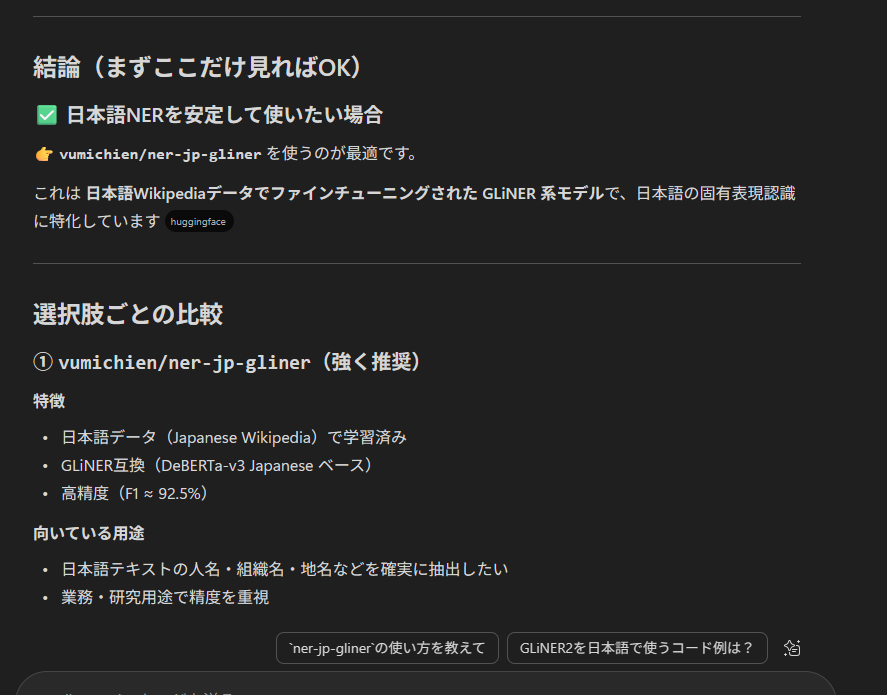

In [2]:
extractorJP = GLiNER2.from_pretrained("vumichien/ner-jp-gliner")

NameError: name 'GLiNER2' is not defined

In [1]:
!pip install gliner

In [2]:
# pip install gliner
from gliner import GLiNER

In [3]:
model_name = "urchade/gliner_medium-v2.1"  # 代替: GLiNER2系列が見つからない場合の保険
model = GLiNER.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

gliner_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/781M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/781M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [7]:
text = """
ソニーグループ株式会社は東京都港区に本社を置く多国籍企業で、2024年に生成AI分野への投資を拡大した。代表取締役会長は吉田憲一郎。
"""

# 日本語で「抽出したいエンティティの意味」を説明（オープンNER）
labels = [
    "企業名: 会社や組織の正式名称",
    "人物名: 人の名前（日本人名・外国人名を含む）",
    "所在地: 本社所在地や住所、地名"
]

entities = model.predict_entities(
    text,
    labels=labels,
    max_length=100,
    threshold=0.35,            # スコア閾値（日本語だと少し低めにするのがコツ）
    span_options={"max_len": 16} # 長い固有表現が多い日本語向けに最大長を少し長めに
)

for e in entities:
    print(e)

{'start': 1, 'end': 30, 'text': 'ソニーグループ株式会社は東京都港区に本社を置く多国籍企業で', 'label': '企業名: 会社や組織の正式名称', 'score': 0.43452590703964233}


In [6]:

# pip install gliner
from gliner import GLiNER

# GLiNER2 系の多言語モデル（例）：モデル名は一例です
# ※ 手元の環境/レジストリに応じて "fastino-ai/gliner2-base" や "gliner2-large" 等を指定
#   もし解決できない場合は v2.1 の多言語モデル（例：urchade/gliner_medium-v2.1）で代替可能
model_name = "urchade/gliner_medium-v2.1"  # 代替: GLiNER2系列が見つからない場合の保険
model = GLiNER.from_pretrained(model_name)

text = """
ソニーグループ株式会社は東京都港区に本社を置く多国籍企業で、
2024年に生成AI分野への投資を拡大した。代表取締役会長は吉田憲一郎。
"""

# 日本語で「抽出したいエンティティの意味」を説明（オープンNER）
labels = [
    "企業名: 会社や組織の正式名称",
    "人物名: 人の名前（日本人名・外国人名を含む）",
    "所在地: 本社所在地や住所、地名"
]

entities = model.predict_entities(
    text,
    labels=labels,
    threshold=0.35,            # スコア閾値（日本語だと少し低めにするのがコツ）
    span_options={"max_len": 16} # 長い固有表現が多い日本語向けに最大長を少し長めに
)

for e in entities:
    print(e)
``


SyntaxError: invalid syntax (ipython-input-824865097.py, line 31)

In [8]:
model = GLiNER.from_pretrained("urchade/gliner_medium-v2.1")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [15]:

text = "トヨタ自動車は愛知県豊田市に本社を置く日本の自動車メーカーである。"

# --- NER（オープン） ---
ner_labels = [
    "企業名: 会社の正式名称",
    "所在地: 都道府県・市区町村などの地名"
]
entities = model.predict_entities(text, labels=ner_labels, threshold=0.1, max_length=12)
print("Entities:", entities)

Entities: [{'start': 0, 'end': 32, 'text': 'トヨタ自動車は愛知県豊田市に本社を置く日本の自動車メーカーである', 'label': '企業名: 会社の正式名称', 'score': 0.11782507598400116}]


In [18]:
extractor = GLiNER2.from_pretrained("fastino/gliner2-large-v1")

NameError: name 'GLiNER2' is not defined

In [23]:
text = "トヨタ自動車は愛知県豊田市に本社を置く日本の自動車メーカーである。"
entities = extractor.extract_entities(
    text,
    {
        "Person": "Names of people, including nobility titles.",
        "Location": "Countries, cities, or geographic places.",
        "Invention": "Machines, devices, or technological creations.",
        "Event": "Historical events, wars, or conflicts."
    }
)
entities

{'entities': {'Person': [], 'Location': [], 'Invention': [], 'Event': []}}

In [25]:
text = "Sixty years later, Bilbo passes on the Ring to Frodo. The Wizard Gandalf discovers it is the One Ring, and warns Frodo to leave. Frodo sets out with Sam, pursued by Sauron's nine Nazgûl servants. They meet Merry and Pippin and evade the Nazgûl, reaching Bree, but Gandalf is not there, captured by the evil Wizard Saruman. A Ranger named Strider guides them to Rivendell, but they are ambushed on Weathertop by the Nazgûl. Their leader stabs Frodo with a Morgul blade. Arwen, Strider's beloved Elf, rescues Frodo. Gandalf escapes from Saruman's tower. Arwen's father Elrond holds a council. It decides the Ring must be destroyed in the fires of Mount Doom. Frodo volunteers to take the Ring, accompanied by eight others. Bilbo gives Frodo his sword Sting, and a mithril mail-shirt."
entities = extractor.extract_entities(
    text,
    {
        "Person": "Names of people, including nobility titles.",
        "Location": "Countries, cities, or geographic places.",
        "Invention": "Machines, devices, or technological creations.",
        "Event": "Historical events, wars, or conflicts."
    }
)
entities

{'entities': {'Person': ['Frodo',
   'Gandalf',
   'Bilbo',
   'Strider',
   'Arwen',
   'Saruman',
   'Pippin',
   'Merry',
   'Elrond',
   'Sam',
   'Sauron'],
  'Location': ['Rivendell', 'Bree', 'Weathertop', 'Mount Doom'],
  'Invention': ['mithril mail-shirt', 'Ring', 'sword Sting', 'Morgul blade'],
  'Event': ['council']}}